# Analyse the CrowdFlower results (gender identification)

In [52]:
%pylab inline
import urllib2
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
import sys
import json
def load_simple_json(filename):
    with open(filename, 'r') as f:
        return json.load(f,encoding="utf-8")

#===== load df with profesion-image correspondences
df_images=pd.read_csv("profession_images_all.csv",sep='\t', encoding='utf-8',index_col=0)
df_with_image=df_images[df_images.image_link!="-"]
df_with_image_without_svg=df_with_image[~df_with_image.image_link.str.contains(".svg")]
df=df_with_image_without_svg[~df_with_image_without_svg.image_link.str.contains(".ogg|.ogv")]
print "Images without .svg and video:",len(df)
print "We have approx",len(df)/float(len(pd.unique(df.profession))),\
"pictures per profession with image. "+"We have",len(pd.unique(df.profession)),"professions with image."
df_unique=df[~df.duplicated('image_link')]
print "Among them ",len(df_unique), "unique images."

#===== load aggregated results:
result_old= pd.read_csv("a725997.csv", delimiter=",", header=0)#results from previous project
result= pd.read_csv("a861276_best.csv", delimiter=",", header=0)#new results

#==== load dictionary with old url to image names correspondences
old_link_name_new=load_simple_json("de/old_link_name_new.json")

Populating the interactive namespace from numpy and matplotlib
Images without .svg and video: 907
We have approx 2.62898550725 pictures per profession with image. We have 345 professions with image.
Among them  889 unique images.


`%matplotlib` prevents importing * from pylab and numpy


In [53]:
#combine images from old results and new results
result_old.loc[:,'no_of_persons']=result_old['no_of_persons'].str.lower().str.replace(r',|\*|\'',"").str.replace(" ","_")
result_old.loc[:,"person_plural"]=result_old["person_plural"].str.lower().str.replace(r',|\)|\(',"").str.replace(" ","_").\
str.replace("i'm_not_sure","gender_is_not_recognizable")
result_old.loc[:,"person_singular_dom"]=result_old["person_singular_dom"].str.lower().str.replace(" ","_").\
str.replace("i'm_not_sure","gender_is_not_recognizable")
result_old.loc[:,"person_singular_nondom"]=result_old["person_singular_nondom"].str.lower().str.replace(" ","_").\
str.replace("i'm_not_sure","gender_is_not_recognizable")
#result_old[(~result_old.person_plural.isnull()) ]

result.loc[:,"real_url"]=result.apply(lambda x: x["image_url"], axis = 1)
old_link_new_link={}
for link in old_link_name_new:
    j=old_link_name_new[link]
    old_link_new_link[link]=df[df.image_name==urllib2.unquote(j.replace("_"," ").encode('utf-8')).decode('utf-8')].image_link.values[0]
old_results_for_or_data=result_old[result_old.image_url.isin(old_link_name_new.keys())]#125
old_results_for_or_data.loc[:,"real_url"]=old_results_for_or_data.apply(lambda x: old_link_new_link[x["image_url"]], axis = 1)
data=pd.concat([result, old_results_for_or_data], ignore_index=True) 
#data #1049 #896-unique
#data[data._unit_state=="finalized"]#893
#data[~data.duplicated('image_url') &(data._unit_state=="finalized") ]#889
#data[(data.person_plural=="i'm_not_sure")|(data.person_singular_dom=="i'm_not_sure")|(data.person_singular_nondom=="i'm_not_sure")]

no_of_persons
image_is_not_shown                                           2
no_person                                                  311
one_person                                                 284
several_persons_but_one_persons_depiction_is_dominant       52
several_persons_no_single_persons_depiction_is_dominant    244
dtype: int64


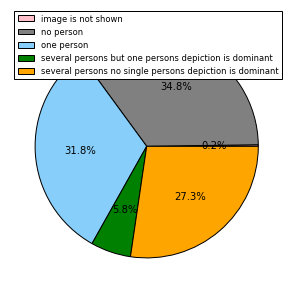

In [54]:
#exclude test questions
result_all= data[data._unit_state == "finalized"]
result_all_grouped =  result_all.groupby("no_of_persons").size()
print result_all_grouped
colors = ['pink',  'grey', 'lightskyblue', 'green', 'orange', 'blue']
plt.figure(1, figsize=(5,5))
plt.pie(result_all_grouped.values, colors=colors, autopct='%1.1f%%') #, pctdistance=1.1, labeldistance=1.2
plt.legend(result_all_grouped.index.str.replace("_"," "),loc="best",fontsize='small')
plt.show()
#plt.savefig("results/answer-types.png", bbox_inches='tight')

In [55]:
#Distribution of images in profession articles on German Wikipedia is
#the same as for profesion articles over all other Wikipedia editions (See Claudia Wagner's research)

There are  580  images with at least one person.
Among them are:

female                         71
gender_is_not_recognizable     18
male                          247
dtype: int64


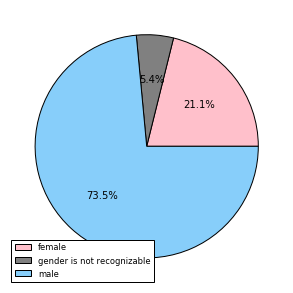

In [56]:
# remove non-person pics
person_docs = result_all[~(result_all.no_of_persons.str.contains("no_person|image_is_not_shown"))] #580
print "There are ",len(person_docs)," images with at least one person."
print "Among them are:"
singular_person_docs = person_docs.groupby("person_singular_nondom").size()
#print singular_person_docs
mult_person_docs_dom = person_docs.groupby("person_singular_dom").size()
#print mult_person_docs_dom
all_singular_persons = mult_person_docs_dom+singular_person_docs
all_singular_persons.keys().name=""#"all_singular_persons"
print all_singular_persons
plt.figure(1, figsize=(5,5))
plt.pie(all_singular_persons.values, colors=colors, autopct='%1.1f%%') #, pctdistance=1.1, labeldistance=1.2
plt.legend(all_singular_persons.index.str.replace("_"," "),loc="best",fontsize='small')
plt.show()

person_plural
gender_is_not_recognizable                        12
mixed_but_predominantly_female_persons            19
mixed_but_predominantly_male_persons              24
mixed_equal_amount_of_male_and_female_persons     43
only_female                                       20
only_male                                        126
dtype: int64


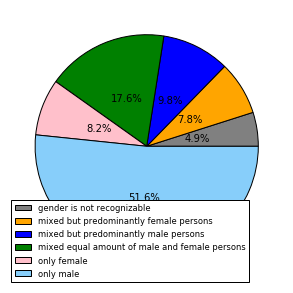

In [57]:
several_people=person_docs.groupby("person_plural").size()

colors = [ 'grey','orange','blue','green', 'pink', 'lightskyblue' ]
print several_people
plt.figure(1, figsize=(5,5))
plt.pie(several_people.values, colors=colors, autopct='%1.1f%%',pctdistance=0.46) #, pctdistance=1.1, labeldistance=1.2
plt.legend(several_people.index.str.replace("_"," "),loc="best",fontsize='small')
plt.show()

In [58]:
df.rename(columns={'image_link':'real_url'}, inplace=True)
result_and_pages = pd.merge(df, person_docs, how="right", on="real_url")#595 (580 unique images)
#result_and_pages


In [59]:
#load about_pages
about_pages=pd.read_csv('de/all_data_bias_labour_gender.csv',sep='\t', encoding='utf-8',index_col=0)#885

#merga all data and image results
df_images_and_all = pd.merge(about_pages,result_and_pages, how="right", on="profession")


# Group by labour market

Amount of data in each group: labor_market_domin
female    202
male      389
dtype: int64



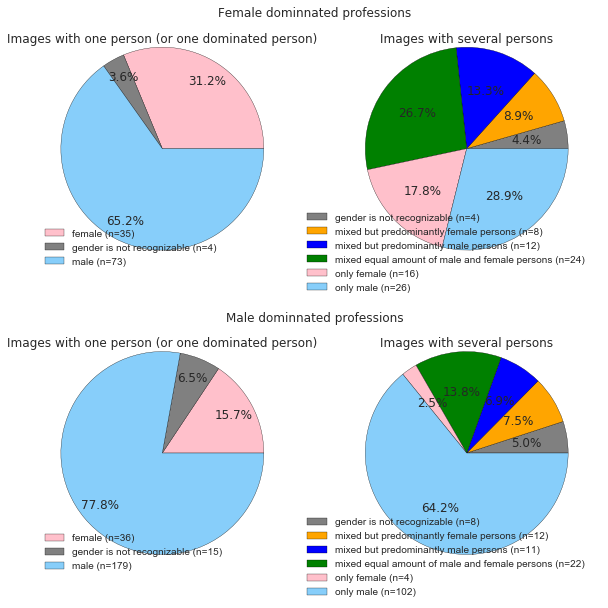

In [163]:
groups=df_images_and_all.groupby("labor_market_domin")
print "Amount of data in each group:",groups.size()
print 
#================hidden subplot
fig, big_axes = plt.subplots( figsize=(10, 10) , nrows=len(groups), ncols=1)
for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title(groups.size().index[row-1].title()+" dominnated professions", fontsize=12)
    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string!
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False
#=================    
    
i=1    
for group_name, df_group in groups:

    #print "Labour market, where dominant are:",group_name
    #=====singular person
    singular = df_group.groupby("person_singular_dom").size()+df_group.groupby("person_singular_nondom").size()
    #print test
    ax1 = fig.add_subplot(len(groups),2,i) 
    colors = ['pink', 'grey','lightskyblue','green','orange','blue']
    ax1.pie(singular.values, colors=colors, autopct='%1.1f%%', pctdistance=0.8)#, labeldistance=1.2
    ax1.legend(singular.index.str.replace("_"," ").values+singular.apply(lambda x:" (n="+str(int(x))+")").values,loc="best",fontsize='small')
    ax1.set_title("Images with one person (or one dominated person)", position=(0.5, 0.9))
    
    #=====plural
    plural= df_group.groupby("person_plural").size()
    #print plural
    ax2 = fig.add_subplot(len(groups),2,i+1)
    colors = [ 'grey','orange','blue','green', 'pink', 'lightskyblue' ]
    ax2.pie(plural.values, colors=colors, autopct='%1.1f%%')#,pctdistance=0.46)
    ax2.legend(plural.index.str.replace("_"," ").values+plural.apply(lambda x:" (n="+str(int(x))+")").values,fontsize='small',bbox_to_anchor=(1, 0.28))#,frameon=False)
    ax2.set_title("Images with several persons", position=(0.5, 0.9))
    i+=2
    #save data
    data[group_name]={"plural":plural.values,"singular":singular.values}
plt.show()

In [218]:
from scipy.stats.distributions import chi2
from scipy.stats import chi2_contingency#,wilcoxon,mannwhitneyu

#===== manual calculation of p-val
def ttes(T):
    PR = T.sum(1) / float(T.sum())
    PC = T.sum(0) / float(T.sum())
    E = np.outer(PR, PC)
    C = T.sum()*E
    cs = ((T-C)**2/C).sum()
    df = (T.shape[0]-1)*(T.shape[1]-1)
    pvalue = 1 - chi2.cdf(cs, df)
    #print cs,pvalue,df
    return cs,pvalue,df,E
#===================

print "Singular persons: "
T=np.array([data["male"]["singular"],data["female"]["singular"]])
print T
print chi2_contingency(T),"\n"#contingency tables -> non-parametric #lambda_="log-likelihood"
print "Several persons: "
T=np.array([data["male"]["plural"],data["female"]["plural"]])
print T
print chi2_contingency(T)
#Fisher's exact test
#scipy.stats.fisher_exact(table, alternative='two-sided')
#Performs a Fisher exact test on a 2x2 contingency table.
#http://vassarstats.net/fisher2x3.html
#http://stats.stackexchange.com/questions/14226/given-the-power-of-computers-these-days-is-there-ever-a-reason-to-do-a-chi-squa/14230#14230
#https://www.mrnoutahi.com/2016/01/03/Fisher-exac-test-for-mxn-table/

#Other solutions:
#1)Simulating the Chi-squared P-value
#One way to check is to simulate the true distribution of the χ2 statistic. R offers a "Monte Carlo" test.
#chisq.test(x, simulate.p.value=TRUE, B=1e5)
#2)Another approach is to bootstrap the test


Singular persons: 
[[ 36  15 179]
 [ 35   4  73]]
(11.6423187416424, 0.0029641665836361319, 2, array([[  47.74853801,   12.77777778,  169.47368421],
       [  23.25146199,    6.22222222,   82.52631579]])) 

Several persons: 
[[  8  12  11  22   4 102]
 [  4   8  12  24  16  26]]
(38.418399929359218, 3.1090695576728627e-07, 5, array([[  7.6626506 ,  12.77108434,  14.68674699,  29.37349398,
         12.77108434,  81.73493976],
       [  4.3373494 ,   7.22891566,   8.31325301,  16.62650602,
          7.22891566,  46.26506024]]))


# Group by bias (from page existance on Wiki)

Amount of data in each group: Bias
female       3
male       548
neutral     44
dtype: int64
no_of_persons
several_persons_no_single_persons_depiction_is_dominant    3
dtype: int64
no_of_persons
one_person                                                 270
several_persons_but_one_persons_depiction_is_dominant       50
several_persons_no_single_persons_depiction_is_dominant    228
dtype: int64
no_of_persons
one_person                                                 22
several_persons_but_one_persons_depiction_is_dominant       3
several_persons_no_single_persons_depiction_is_dominant    19
dtype: int64


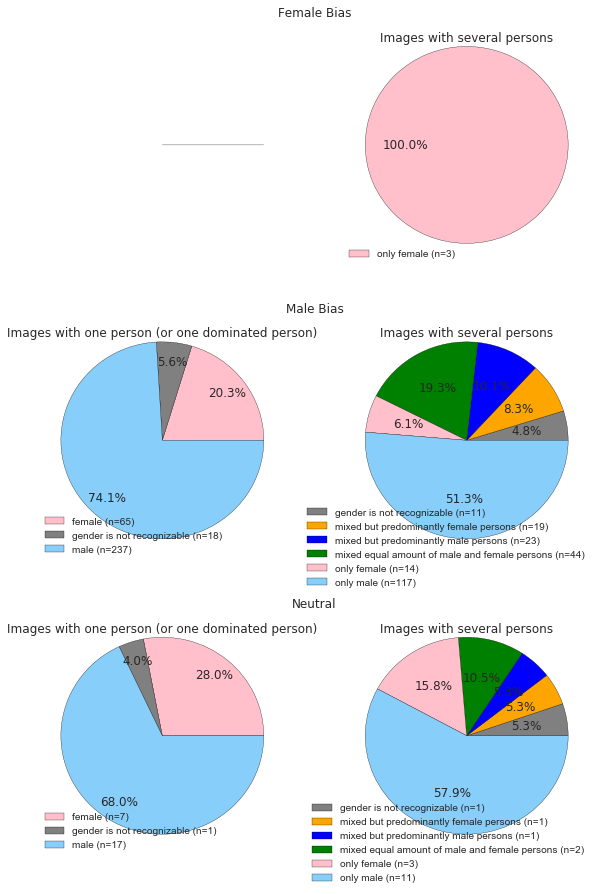

In [219]:
groups=df_images_and_all.groupby("Bias")
print "Amount of data in each group:",groups.size()

#================hidden subplot
fig, big_axes = plt.subplots( figsize=(10, 5*len(groups)) , nrows=len(groups), ncols=1)
for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title(groups.size().index[row-1].title() if groups.size().index[row-1]=="neutral" else groups.size().index[row-1].title()+" Bias", fontsize=12)
    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string!
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False
#=================    
  
data={}
i=1    
for group_name, df_group in groups:
    num_of_pers =  df_group.groupby("no_of_persons").size()
    print num_of_pers
    #print "Bias:",group_name
    #=====singular person
    if (df_group.person_singular_dom.count()>0) | (df_group.person_singular_nondom.count()>0):#
        #singular = df_group.groupby("person_singular_dom").size()+df_group.groupby("person_singular_nondom").size()
        singular=df_group.groupby("person_singular_dom").size().add(df_group.groupby("person_singular_nondom").size(),fill_value=0)
        #print test
        ax1 = fig.add_subplot(3,2,i) 
        colors = ['pink', 'grey','lightskyblue','green','orange','blue']
        ax1.pie(singular.values, colors=colors, autopct='%1.1f%%', pctdistance=0.8)#, labeldistance=1.2)
        ax1.legend(singular.index.str.replace("_"," ").values+singular.apply(lambda x:" (n="+str(int(x))+")").values,loc="best",fontsize='small')
        ax1.set_title("Images with one person (or one dominated person)", position=(0.5, 0.9))
        singular_values=singular.values
    else:
        ax1 = fig.add_subplot(3,2,i) 
        ax1.pie([0])
        ax1.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        ax1._frameon = False
        singular_values=np.array([0,0,0])
    #=====plural
    plural= df_group.groupby("person_plural").size()
    plural_values=plural.values
    #print plural
    ax2 = fig.add_subplot(3,2,i+1)
    if len(plural)==1:
        colors = ['pink']
        plural_values=np.array([plural.values[0],0,0,0,0,0])
    else:
        colors = [ 'grey','orange','blue','green', 'pink', 'lightskyblue' ]
    ax2.pie(plural.values, colors=colors, autopct='%1.1f%%')#,pctdistance=0.46)
    ax2.set_title("Images with several persons", position=(0.5, 0.9))
    if len(plural)>4:
        ax2.legend(plural.index.str.replace("_"," ").values+plural.apply(lambda x:" (n="+str(int(x))+")").values,fontsize='small',bbox_to_anchor=(1, 0.26))#,frameon=False)
    else:
        ax2.legend(plural.index.str.replace("_"," ").values+plural.apply(lambda x:" (n="+str(int(x))+")").values,loc=3,fontsize='small')
    
    i+=2
    data[group_name]={"plural":plural_values,"singular":singular_values}
plt.show()

In [220]:
print data["female"]["singular"]
T=np.array([data["male"]["singular"],data["neutral"]["singular"]])
print T
print chi2_contingency(T)

[0 0 0]
[[  65.   18.  237.]
 [   7.    1.   17.]]
(0.88358517017198479, 0.64288296514270238, 2, array([[  66.7826087 ,   17.62318841,  235.5942029 ],
       [   5.2173913 ,    1.37681159,   18.4057971 ]]))


In [221]:
print data["female"]["plural"],
T=np.array([data["male"]["plural"],data["neutral"]["plural"]])
print T
print chi2_contingency(T)

[3 0 0 0 0 0] [[ 11  19  23  44  14 117]
 [  1   1   1   2   3  11]]
(3.8749210757672632, 0.56756129494269936, 5, array([[  11.07692308,   18.46153846,   22.15384615,   42.46153846,
          15.69230769,  118.15384615],
       [   0.92307692,    1.53846154,    1.84615385,    3.53846154,
           1.30769231,    9.84615385]]))


In [ ]:
#Null hypothesis: Images in Male bias has the same distibution of gender as in neutral bias group.
#We cannot reject null hypothesis (p=0.64,p=0.56 )

In [224]:
#both cateories of images together
print chi2_contingency([[65,18,237,11,19,23,44,14,117],[7,1,17,1,1,1,2,3,11]])

(4.9039513317710934, 0.7677909177416653, 8, array([[  66.64864865,   17.58783784,  235.12162162,   11.10810811,
          18.51351351,   22.21621622,   42.58108108,   15.73648649,
         118.48648649],
       [   5.35135135,    1.41216216,   18.87837838,    0.89189189,
           1.48648649,    1.78378378,    3.41891892,    1.26351351,
           9.51351351]]))


# Group by gender of profession label

Amount of data in each group: prof_gender
female      12
male       558
neutral     25
dtype: int64
no_of_persons
one_person                                                 5
several_persons_no_single_persons_depiction_is_dominant    7
dtype: int64
no_of_persons
one_person                                                 278
several_persons_but_one_persons_depiction_is_dominant       51
several_persons_no_single_persons_depiction_is_dominant    229
dtype: int64
no_of_persons
one_person                                                  9
several_persons_but_one_persons_depiction_is_dominant       2
several_persons_no_single_persons_depiction_is_dominant    14
dtype: int64


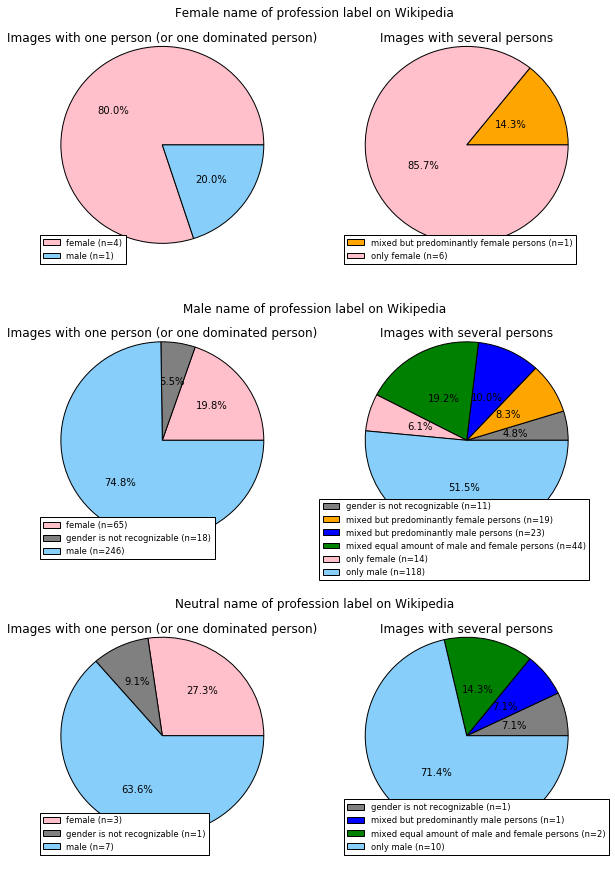

In [347]:
groups=df_images_and_all.groupby("prof_gender")
print "Amount of data in each group:",groups.size()

#================hidden subplot
fig, big_axes = plt.subplots( figsize=(10, 5*len(groups)) , nrows=len(groups), ncols=1)
for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title(""+groups.size().index[row-1].title()+" name of profession label on Wikipedia", fontsize=12)
    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string!
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False
#=================    
    
i=1    
for group_name, df_group in groups:
    num_of_pers =  df_group.groupby("no_of_persons").size()
    print num_of_pers

    #=====singular person
    if (df_group.person_singular_dom.count()>0) | (df_group.person_singular_nondom.count()>0):#
        if (df_group.person_singular_dom.count()>0) & (df_group.person_singular_nondom.count()>0):
            singular=df_group.groupby("person_singular_dom").size().add(df_group.groupby("person_singular_nondom").size(),fill_value=0)
        elif (df_group.person_singular_dom.count()>0):
            singular=df_group.groupby("person_singular_dom").size()
        else:
            singular=df_group.groupby("person_singular_nondom").size()
        #print singular
        ax1 = fig.add_subplot(3,2,i) 
        if len(singular)==2:
            colors = ['pink', 'lightskyblue']
        else:
            colors = ['pink', 'grey','lightskyblue','green','ccccc','blue']
        ax1.pie(singular.values, colors=colors, autopct='%1.1f%%') #, pctdistance=1.1, labeldistance=1.2
        ax1.legend(singular.index.str.replace("_"," ").values+singular.apply(lambda x:" (n="+str(int(x))+")").values,loc=3,fontsize='small')
        ax1.set_title("Images with one person (or one dominated person)", position=(0.5, 0.9))
    else:
        ax1 = fig.add_subplot(3,2,i) 
        ax1.pie([0])
        ax1.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        ax1._frameon = False
    #=====plural
    plural= df_group.groupby("person_plural").size()
    #print plural
    ax2 = fig.add_subplot(3,2,i+1)
    if len(plural)==1:
        colors = ['pink']
    elif len(plural)==2:
        colors = ['orange', 'pink']
    elif len(plural)==4:
        colors = ['grey','blue','green', 'lightskyblue']
    else:
        colors = [ 'grey','orange','blue','green', 'pink', 'lightskyblue' ]
    ax2.pie(plural.values, colors=colors, autopct='%1.1f%%',pctdistance=0.48)
    ax2.set_title("Images with several persons", position=(0.5, 0.9))
    if len(plural)<5:
        ax2.legend(plural.index.str.replace("_"," ").values+plural.apply(lambda x:" (n="+str(int(x))+")").values,loc=3,fontsize='small')
    else:
        ax2.legend(plural.index.str.replace("_"," ").values+plural.apply(lambda x:" (n="+str(int(x))+")").values,fontsize='small',bbox_to_anchor=(1, 0.28))#,frameon=False)
        
    i+=2
plt.show()

# More:

There are 53.6% man and 46.4% woman according to German labour Market statistics.
Statistics about professions that are described on Wikipedia: 62.1% man and 37.9% woman in German Labour market.
We combined singular persons and several persons according to magority (male or female):
female     95
male      346
dtype: float64


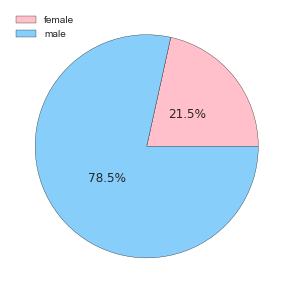

In [200]:
import pandas as pd
#From German labour Market Statistics (2015):
m_n=16504172#Männer 
f_n=14267125#Frauen 
m_proc=100*float(m_n)/(m_n+f_n)
f_proc=100-m_proc
print "There are {0:.1f}% man and {1:.1f}% woman according to German labour Market statistics.".format(m_proc,f_proc)
#===data where if there are male and female profession then statistics count it 2 times:
#all_df=pd.read_csv("de/labour_market_for_all_pages.csv",sep='\t', encoding='utf-8',index_col=0)
#f_wiki_proc=all_df.Frauen.mean()
#m_wiki_proc=100-f_wiki_proc
#print "There are {0:.1f}% man and {1:.1f}% woman according to German labour Market statistics.".format(m_wiki_proc,f_wiki_proc)
#===
df_all_subgroups=pd.read_csv("de/labourmarket_subgroups.csv",sep='\t', encoding='utf-8',index_col=0)
f_wiki_proc=df_all_subgroups.Frauen_ratio.mean()
m_wiki_proc=100-f_wiki_proc
print "Statistics about professions that are described on Wikipedia: {0:.1f}% man and {1:.1f}% woman in German Labour market.".format(m_wiki_proc,f_wiki_proc)

person_all=person_docs[~(person_docs.no_of_persons.str.contains("no_person|image_is_not_shown"))]
person_all.loc[:,'person_plural']=result_old['person_plural'].str.replace("only_","")\
    .str.replace("mixed_but_predominantly_","").str.replace("_persons","")
all_singular_persons = person_all.groupby("person_singular_dom").size()+person_all.groupby("person_singular_nondom").size()
several_people=person_all.groupby("person_plural").size()
new_all=several_people.add(all_singular_persons ,fill_value=0).drop(["gender_is_not_recognizable",
                                                                     "mixed_equal_amount_of_male_and_female"])

print "We combined singular persons and several persons according to magority (male or female):\n",new_all
plt.figure(1, figsize=(5,5))
colors = ['pink', 'lightskyblue']
plt.pie(new_all.values, colors=colors,autopct='%1.1f%%',pctdistance=0.46) #, pctdistance=1.1, labeldistance=1.2
plt.legend(new_all.index,loc="best",fontsize='small')
plt.show()
#print person_all[pd.notnull(person_all['person_plural'])].person_plural.value_counts(normalize=True,dropna=False)
f_perc_all=100. * new_all.female / (new_all.female+new_all.male)
m_perc_all=100. * new_all.male / (new_all.female+new_all.male)

In [213]:
from scipy.stats import chisquare,ks_2samp,chi2_contingency

cat1=[df_all_subgroups.Frauen.mean(),df_all_subgroups[u'Männer'].mean()]
print cat1
cat2=new_all.values
print cat2
print chi2_contingency(np.array([cat1, cat2]))
#print ks_2samp(cat1, cat2)#samples are drawn from the same distribution?
print chisquare(np.array([cat1,cat2]))#goodnes of fit

[20593.8969521045, 23784.43396226415]
[  95.  346.]
(107.6173410810016, 3.2602012391591332e-25, 1, array([[ 20485.32846124,  23893.00245313],
       [   203.56849087,    237.43150913]]))
Power_divergenceResult(statistic=array([ 20310.64184938,  22766.27877735]), pvalue=array([ 0.,  0.]))


In [ ]:
#If data are not normally distributed -> use  Box-Cox power transformation of data